In [16]:
import pandas as pd
import numpy as np
from nfstream import NFStreamer, NFPlugin
import os
from scapy.all import *
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.model_selection import train_test_split
import collections
import torch
import torch.nn as nn
import torch.optim as optim
import intel_extension_for_pytorch as ipex

In [17]:
path = os.path.abspath("") + '/../datasets/' 
benign_path = path + 'classification/benign.pcap'
sql_inj_path = path + 'classification/sql-injection.pcap'
xss_path = path + 'classification/xss.pcapng'
ddos_path = path + 'classification/ddos'
portscan_path = path + 'classification/portscan/part'
to_drop = [
    'bidirectional_first_seen_ms',
    'bidirectional_last_seen_ms',
    'src2dst_first_seen_ms',
    'src2dst_last_seen_ms',
    'dst2src_first_seen_ms',
    'dst2src_last_seen_ms',
    'src_ip', 'dst_ip', 
    'protocol', 'src_oui', 
    'ip_version', 'dst_oui', 
    'application_name', 'application_category_name', 
    'vlan_id', 'expiration_id', 
    'content_type', 'client_fingerprint', 
    'server_fingerprint', 'user_agent', 
    'requested_server_name', 'src_mac', 
    'dst_mac', 'application_is_guessed', 
    'application_confidence', 'tunnel_id', 'id'
]

attacks = {
    'BENIGN': 0,
    'SQL_INJ': 1,
    'XSS': 2,
    'DDOS': 3,
    'PORTSCAN': 4
}

filemap = [
    (attacks['BENIGN'], benign_path),
    (attacks['SQL_INJ'], sql_inj_path),
    (attacks['XSS'], xss_path),
    (attacks['DDOS'], ddos_path),
    (attacks['PORTSCAN'], portscan_path)
]
device = torch.device("xpu" if torch.xpu.is_available() else "cpu")
print(device)

xpu


In [18]:
class PacketsCollector(NFPlugin):
    def __init__(self, packet_limit):
        self.packet_limit = packet_limit
    def get_packet(self, packet):
        byte_counter = collections.Counter(packet.ip_packet)
        distro = [byte_counter.get(byte, 0) for byte in range(256)]
        return distro
    def on_init(self, packet, flow):
        flow.udps.packets = [self.get_packet(packet)]
    def on_update(self, packet, flow):
        if (len(flow.udps.packets) < self.packet_limit):
            flow.udps.packets.append(self.get_packet(packet))  
    def on_expire(self, flow):
        if (len(flow.udps.packets) < self.packet_limit):
            diff = self.packet_limit - len(flow.udps.packets) 
            for i in range(diff):
                distro = [0 for i in range(256)]
                flow.udps.packets.append(distro)

In [19]:
def get_flows(filename, label):
    streamer = NFStreamer(source=filename, udps = PacketsCollector(15))
    df = []
    for flow in streamer:
        packets = flow.udps.packets
        df.append(packets)
    df = np.array(df)
    train, test = train_test_split(df, train_size=0.7)
    test, val = train_test_split(test, train_size=0.85)
    return train, test, val
    
train_df = []
test_df = []
val_df = []
train_labels = []
test_labels = []
val_labels = []
for label, path in filemap:
    print(path)
    train, test, val = get_flows(path, label)
    train_df.extend(train)
    test_df.extend(test)
    val_df.extend(val)
    train_labels.extend([label for i in range(len(train))])
    test_labels.extend([label for i in range(len(test))])
    val_labels.extend([label for i in range(len(val))])
    

/jupyter/shared/../datasets/classification/benign.pcap
/jupyter/shared/../datasets/classification/sql-injection.pcap
/jupyter/shared/../datasets/classification/xss.pcapng
/jupyter/shared/../datasets/classification/ddos
/jupyter/shared/../datasets/classification/portscan/part


## One-hot encode labels
0 -> [1 0 0 0 0] 

1 -> [0 1 0 0 0]
...

In [20]:
train_labels = np.array(train_labels)
def oh_encode(labels):
    oh_labels = np.zeros((len(labels), len(attacks)))
    oh_labels[np.arange(labels.size), labels] = 1 
    return oh_labels
oh_train_labels = oh_encode(np.array(train_labels))
oh_test_labels = oh_encode(np.array(test_labels))
oh_val_labels = oh_encode(np.array(val_labels))

In [8]:
def preprocess(data, scaler, fit = False):
    num_samples, num_packets, num_features = data.shape
    X_reshaped = data.reshape(-1, num_features)

    if fit: X_scaled = scaler.fit_transform(X_reshaped)
    else: X_scaled = scaler.transform(X_reshaped)

    X_scaled = X_scaled.reshape(num_samples, num_packets, num_features)
    return X_scaled
    
scaler = StandardScaler()
X_train = preprocess(np.array(train_df), scaler, fit=True)
X_test = preprocess(np.array(test_df), scaler, fit=False)
X_val = preprocess(np.array(val_df), scaler, fit=False)

In [10]:
num_samples_train, num_packets_train, num_features_train = X_train.shape
num_samples_test, num_packets_test, num_features_test = X_test.shape
num_samples_val, num_packets_val, num_features_val = X_val.shape
print(f'TRAIN: Num samples: {num_samples_train}, num_packets: {num_packets_train}, num_features: {num_features_train}, num_labels: {len(train_labels)}')
print(f'TEST: Num samples: {num_samples_test}, num_packets: {num_packets_test}, num_features: {num_features_test}, num_labels: {len(test_labels)}')
print(f'VAL: Num samples: {num_samples_val}, num_packets: {num_packets_val}, num_features: {num_features_val}, num_labels: {len(val_labels)}')

TRAIN: Num samples: 12342, num_packets: 15, num_features: 256, num_labels: 12342
TEST: Num samples: 4495, num_packets: 15, num_features: 256, num_labels: 4495
VAL: Num samples: 797, num_packets: 15, num_features: 256, num_labels: 797


In [11]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMClassifier, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [12]:
from torch.utils.data import DataLoader, TensorDataset
X_train_tensor = torch.tensor(X_train)
X_test_tensor = torch.tensor(X_test)
y_train_tensor = torch.tensor(oh_train_labels, dtype=torch.float32)
y_test_tensor = torch.tensor(oh_test_labels, dtype=torch.float32)

In [11]:
y_train_tensor

tensor([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.]])

In [27]:
batch_size = 12
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

NameError: name 'val_dataset' is not defined

In [18]:
for batch in train_loader:
    break
print(f'Batch inputs shape: {batch[0].shape}')
print(f'Batch outputs shape: {batch[1].shape}')

Batch inputs shape: torch.Size([12, 15, 256])
Batch outputs shape: torch.Size([12, 5])


In [28]:
input_size = train_dataset[0][0].shape[1]
hidden_size = 40
num_layers = 2
output_size = train_dataset[0][1].shape[0]
model = LSTMClassifier(input_size, hidden_size, num_layers, output_size).to(device)

In [29]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
history = []
# Training loop
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    val_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.float().to(device), batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step() 
        total_loss += loss.item()

    with torch.no_grad():
        model.eval()
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.float().to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
    # print('outside for')
    history.append({'epoch': num_epochs, 'loss': total_loss, 'val_loss': val_loss})
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss}, Val. loss: {val_loss}")

Epoch [1/20], Loss: 349.13563665386755, Val. loss: 18.803862688480876
Epoch [2/20], Loss: 30.31900784757454, Val. loss: 10.356928664667066
Epoch [3/20], Loss: 14.6191234026046, Val. loss: 7.359513306757435
Epoch [4/20], Loss: 11.373104791229707, Val. loss: 8.653201986016938


KeyboardInterrupt: 

In [26]:
epoch = 1
for item in attack_history:
    item['epoch'] = epoch
    epoch = epoch +1

In [28]:
attack_history
with open('attack_train.npy', 'wb') as f:
    np.save(f, attack_history)

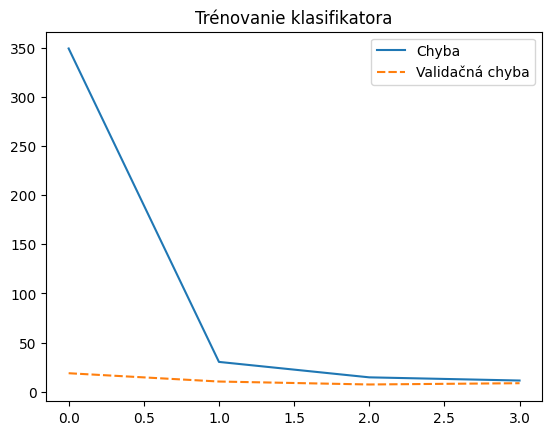

In [33]:
attack_history = np.load('attack_train.npy', allow_pickle=True)
stats = pd.DataFrame(list(attack_history))
stats = stats.drop(columns=['epoch'])
stats.columns = ['Chyba', 'Validačná chyba']
sns.lineplot(stats).set_title("Trénovanie klasifikatora")
plt.savefig('attack_final.png')

In [65]:
torch.save(model, os.path.abspath("") + '/models/attack_final.pth')

In [33]:
joblib.dump(scaler, 'models/att_scaler_final.gz')

['models/att_scaler_final.gz']